#### 受力变形comsol结果检测

使用手动求导，分析comsol计算结果是否满足给定方程。精度与取点密度有关

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
E= 420*10**9 #杨氏模量
mu =0.14 #泊松比
G=E/2/(1+mu)  #剪切模量
alpha=4*10**-6 #线膨胀系数
beta=alpha *E /(1-2*mu) #热应力系数

fem=pd.read_csv('./data/3_P_1_u_200.txt',delimiter=r'\s+')

In [4]:
def manual_diff_r(u,r,num=200):
    u=u.reshape((num,num)).T
    r=r.reshape((num,num)).T
    du_dr = np.zeros_like(u)
    for i in range(num): #行
        for j in range(num): #列
            if j==0:
                du_dr[i][j]=(u[i][j+1]-u[i][j])/(r[i][j+1]-r[i][j])
            elif j==num-1:
                du_dr[i][j]=(u[i][j]-u[i][j-1])/(r[i][j]-r[i][j-1])
            else:
                du_dr[i][j]=(u[i][j+1]-u[i][j-1])/(r[i][j+1]-r[i][j-1])


    return du_dr.flatten(order='F')

def manual_diff_z(u,z,num=200):
    u=u.reshape((num,num)).T
    z=z.reshape((num,num)).T
    du_dz = np.zeros_like(u)
    for i in range(num): #列
        for j in range(num): #行
            if j==0:
                du_dz[j][i]=(u[j+1][i]-u[j][i])/(z[j+1][i]-z[j][i])
            elif j==num-1:
                du_dz[j][i]=(u[j][i]-u[j-1][i])/(z[j][i]-z[j-1][i])
            else:
                du_dz[j][i]=(u[j+1][i]-u[j-1][i])/(z[j+1][i]-z[j-1][i])


    return du_dz.flatten(order='F')

In [5]:
num=200

u_f=fem['u'].values
r_f=fem['R'].values
w_f=fem['w'].values
z_f=fem['Z'].values

du_dr=manual_diff_r(u_f,r_f,num)
dw_dz=manual_diff_z(w_f,z_f,num)
dw_dr=manual_diff_r(w_f,r_f,num)
du_dz=manual_diff_z(u_f,z_f,num)

sigma_rr=2*G * ((1-mu)/(1-2*mu)*du_dr + mu/(1-2*mu)*(u_f/r_f+dw_dz)) *10**-12
sigma_theta=2*G * ((1-mu)/(1-2*mu)*u_f/r_f + mu/(1-2*mu)*(dw_dz+du_dr)) *10**-12
sigma_zz=2*G * ((1-mu)/(1-2*mu)*dw_dz + mu/(1-2*mu)*(u_f/r_f+du_dr)) *10**-12
sigma_zr=G*(dw_dr+du_dz)*10**-12

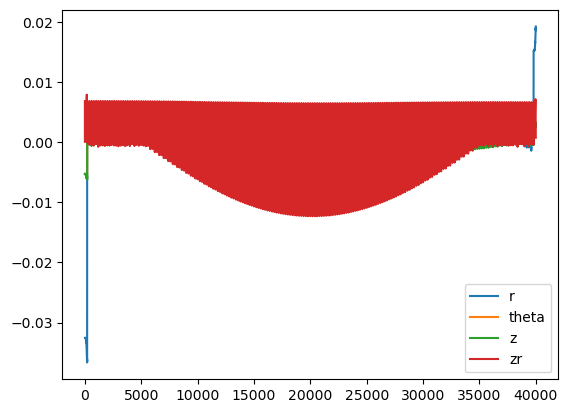

In [19]:
sigma_rr_fem=fem['solid.sr'].values
sigma_theta_fem=fem['solid.sphi'].values
sigma_zz_fem=fem['solid.sz'].values
sigma_zr_fem=fem['solid.srz'].values
plt.plot(sigma_rr_fem-sigma_rr,label='r')
plt.plot(sigma_theta_fem-sigma_theta,label='theta')
plt.plot(sigma_zz_fem-sigma_zz,label='z')
plt.plot(sigma_zr_fem-sigma_zr,label='zr')
plt.legend()
plt.show()

-0.004348702608089985
0.00036060562774284366


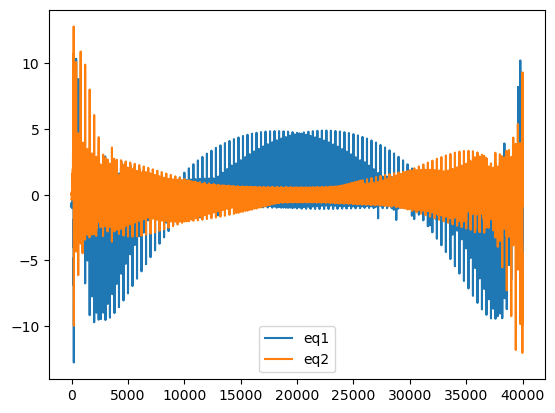

In [17]:
d_sigma_r_dr=manual_diff_r(sigma_rr_fem,r_f)
d_sigma_zr_dz=manual_diff_z(sigma_zr_fem,z_f)
d_sigma_z_dz=manual_diff_z(sigma_zz_fem,z_f)
d_sigma_zr_dr=manual_diff_r(sigma_zr_fem,r_f)
eq1=d_sigma_r_dr+d_sigma_zr_dz+(sigma_rr_fem-sigma_theta_fem)/r_f
eq2=d_sigma_z_dz+d_sigma_zr_dr+sigma_zr_fem/r_f
print(np.mean(eq1))
print(np.mean(eq2))
plt.plot(eq1,label='eq1')
plt.plot(eq2,label='eq2')
plt.legend()
plt.show()